Makemore pt3
Use an RNN to model a character level language model.
[Video](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4)

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random

In [8]:
# Mac OS GPU acceleration or CPU
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [9]:
# Load names from file
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [10]:
# Create vocab of characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print('stoi', stoi)
print('itos', itos)
vocab_size = len(itos)


stoi {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
# Create dataset
block_size = 4 # char context length

def build_dataset(words):
    X, Y = [], [] # X = Data, Y = Target
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # next char to be predicted and added to context
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

train_n = int(len(words) * 0.8)
dev_n = int(len(words) * 0.1)
test_n = len(words) - train_n - dev_n
random.shuffle(words)
train_words = words[:train_n]
dev_words = words[train_n:train_n+dev_n]
test_words = words[train_n+dev_n:]

train_X, train_Y = build_dataset(train_words)
dev_X, dev_Y = build_dataset(dev_words)
test_X, test_Y = build_dataset(test_words)

In [22]:
# Define the MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g, device=device) * (5/3) / ((block_size * n_embd)**0.5) # Optimising the initialisations for the activation function, yields 5% better loss.
W1 = torch.randn((block_size * n_embd,n_hidden), generator=g, device=device) * 0.01
# b1 = torch.randn(n_hidden, generator=g, device=device) # Bias is not needed for batch norm, it is redunant because the addition
W2 = torch.randn((n_hidden,vocab_size), generator=g, device=device)  * 0.01 # We squash the weights to have better initialisation loss. network ends up training for longer in the "hard" part of the loss curve so we get a better result. 5% better loss.
b2 = torch.randn(vocab_size, generator=g, device=device) * 0

# Batch norm gain and shift
bngain = torch.ones((1, n_hidden), device=device)
bnbias = torch.zeros((1, n_hidden), device=device)
bnmean_running = torch.zeros((1, n_hidden), device=device)
bnstd_running = torch.ones((1, n_hidden), device=device)

# Sum number of parameters
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


14297


  0%|          | 340/200000 [00:00<01:56, 1717.89it/s]

      0/ 200000 loss: 3.2890


  5%|▌         | 10275/200000 [00:05<01:22, 2287.73it/s]

  10000/ 200000 loss: 2.5566


 10%|█         | 20379/200000 [00:09<01:34, 1907.43it/s]

  20000/ 200000 loss: 2.1149


 15%|█▌        | 30247/200000 [00:14<01:15, 2245.22it/s]

  30000/ 200000 loss: 2.0101


 20%|██        | 40227/200000 [00:19<01:13, 2159.15it/s]

  40000/ 200000 loss: 2.4374


 25%|██▌       | 50218/200000 [00:24<01:15, 1983.83it/s]

  50000/ 200000 loss: 2.1875


 30%|███       | 60283/200000 [00:29<01:11, 1945.65it/s]

  60000/ 200000 loss: 2.3115


 35%|███▌      | 70391/200000 [00:34<01:04, 2019.16it/s]

  70000/ 200000 loss: 2.2184


 40%|████      | 80315/200000 [00:38<00:53, 2223.62it/s]

  80000/ 200000 loss: 1.9384


 45%|████▌     | 90338/200000 [00:43<00:48, 2250.59it/s]

  90000/ 200000 loss: 2.0786


 50%|█████     | 100319/200000 [00:47<00:45, 2178.92it/s]

 100000/ 200000 loss: 2.1461


 55%|█████▌    | 110236/200000 [00:52<00:40, 2242.61it/s]

 110000/ 200000 loss: 2.2325


 60%|██████    | 120264/200000 [00:56<00:35, 2260.14it/s]

 120000/ 200000 loss: 1.9688


 65%|██████▌   | 130332/200000 [01:01<00:30, 2271.13it/s]

 130000/ 200000 loss: 1.8845


 70%|███████   | 140349/200000 [01:05<00:26, 2268.67it/s]

 140000/ 200000 loss: 2.0723


 75%|███████▌  | 150395/200000 [01:10<00:21, 2290.26it/s]

 150000/ 200000 loss: 2.2657


 80%|████████  | 160212/200000 [01:14<00:17, 2273.18it/s]

 160000/ 200000 loss: 1.8135


 85%|████████▌ | 170239/200000 [01:18<00:13, 2250.65it/s]

 170000/ 200000 loss: 2.0422


 90%|█████████ | 180307/200000 [01:23<00:08, 2277.84it/s]

 180000/ 200000 loss: 2.1032


 95%|█████████▌| 190321/200000 [01:27<00:04, 2263.52it/s]

 190000/ 200000 loss: 1.7874


100%|██████████| 200000/200000 [01:32<00:00, 2173.33it/s]


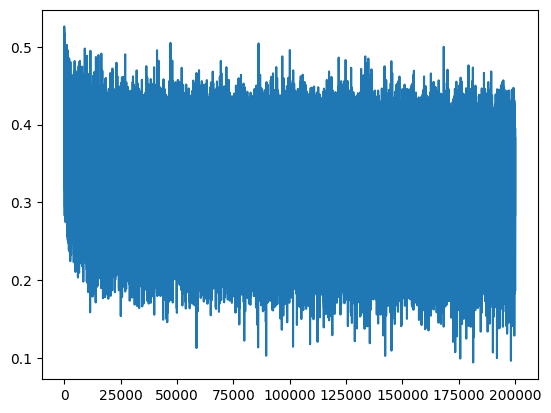

In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps)):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass

    # embedding layer
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    # Linear layer
    hpreact = embcat @ W1 # no + b1 because batch norm makes it redundant. bias term is a single number.
    
    # Batch Norm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch norm
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())


# Plot
plt.plot(lossi)

In [25]:
# Using batch norm during inference of single examples requires you to compute the mean and std of the training set and add that in as a hardcoded parameter
with torch.no_grad():
    emb = C[train_X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    print(bnmean)
    bnstd = hpreact.std(0, keepdim=True)
    print(bnstd)

# We don't need to do this if we use bnmean_running and bnstd_running to compute the mean and std of the training set

tensor([[ 2.0501, -0.4823,  0.8330,  0.7686, -2.4285, -1.3489,  0.4790,  0.8979,
         -1.3777,  0.2078, -0.3131,  0.9474, -0.5770,  0.1460,  0.4954,  1.0983,
          0.1771,  0.5988, -0.7540, -0.6818, -0.9983, -0.1928,  0.6701,  0.1255,
          0.5310, -0.2607,  1.4380,  0.2180,  0.3307, -0.9400,  0.2482,  0.3263,
          0.2739,  0.4451, -1.4892,  0.7303, -2.9002, -0.4240, -0.8585, -0.4043,
         -0.9640, -0.6637, -1.3224,  0.2194, -1.3642,  0.8533,  1.7854, -0.8660,
         -2.0476, -0.8378,  0.4281, -0.7312, -0.1589, -0.1882,  0.4976,  0.0030,
         -0.6983,  0.4439,  1.4440,  0.5921, -1.0250, -0.5139,  0.3596, -1.8680,
          0.5884,  1.4150,  0.0963,  0.4888,  0.1622, -0.6708,  0.8227,  0.4011,
          0.6368,  0.3564,  0.2669, -1.5223, -0.6821, -0.2372,  1.4802,  0.8002,
          0.6372,  0.9224,  1.5949,  1.0244, -0.5055,  2.8413,  0.6902, -1.7874,
          0.1985, -0.1025,  0.9718,  1.2776, -1.9533,  1.7986, -2.2189, -0.1764,
          0.0834,  1.6959, -

In [29]:
# Evaluation
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (train_X, train_Y),
        'dev': (dev_X, dev_Y),
        'test': (test_X, test_Y),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch norm

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')
split_loss('train')
split_loss('dev')
split_loss('test')

train loss: 2.0186
dev loss: 2.0711
test loss: 2.0596


Test Loss to beat

With BatchNorm:
train loss: 2.0184
dev loss: 2.0706
test loss: 2.0592

In [18]:
# Sampling from model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

caamaheaae.
heel.
kemle.
eeety.
eaaassae.
eaheee.
eeesaha.
eaeei.
.
eemaea.
ceeiiv.
es.
eeepe.
am.
eeay.
eesa.
es.
oelea.
.
aebi.


In [14]:
# Expected loss at initialisation assuming equal distribution
loss = - torch.log(torch.tensor(1/27)) # probability of each character is 1/27 naively and this is how the loss should be calculated.
print(loss)
# Random initialisation of the network is leading to high loss. You can reduce the values of the weights of network at initialisation so the softmaxed outputs are less extreme.

tensor(3.2958)
